In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/scripts"))
import auxiliar as aux
import geometry as geom

# Configuration and paths

In [6]:
source_name = "crab"

# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/analysis_scaling_correlations/"
# Data main directory
root_data = root + f"../../data/cosmic_ray_data_correction/{source_name}/"
dir_objects = "/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/analysis_weather/objects"

# directories for the data
dir_dl1b = root_data + "dl1b/"
dir_dl2  = root_data + "dl2/"

# Read dl2 data for all subruns available

In [7]:
run_dirs = [name for name in os.listdir(dir_dl2) if os.path.isdir(os.path.join(dir_dl2, name))]

DICTS = []

for rundir in run_dirs:
    dir_dl2_run = dir_dl2 + rundir
    
    files = glob.glob(dir_dl2_run + "/*")
    
    sruns = np.unique([int(f.split(".")[-3][:-3]) for f in files])
    
    for srun in sruns:
        dir_dl2_srun = dir_dl2_run + f"/*.{srun:04}_*"
        files_srun = glob.glob(dir_dl2_srun)
        
        _dict = {
            "run" : int(rundir),
            "srun" : srun, 
            "scale" : {},
        }
        
        for f in files_srun:
            
            scale = float(f.split("_s")[-1].split(".h5")[0])
            
            _dict["scale"][scale] = pd.read_hdf(f, key="dl2/event/telescope/parameters/LST_LSTCam")
            
        DICTS.append(_dict)

# Read datacheck data

In [39]:
with open(dir_objects + "/data_dict.pkl", 'rb') as f:
    dict_dcheck = pickle.load(f)   

In [41]:
runs_list, sruns_list = [], []
for DICT in DICTS:
    _run  = DICT["run"]
    _srun = DICT["srun"]
    
    runs_list.append(_run)
    sruns_list.append(_srun)
    
    mask_run  = (dict_dcheck["run"] == 8367)
    mask_srun = (dict_dcheck["srun"] == 1)
    
    index = list(mask_run & mask_srun).index(True)
    
    dcheck_info = {}
    for key in dict_dcheck.keys():
        
        dcheck_info[key] = dict_dcheck[key][index]
    
    DICT["dcheck"] = dcheck_info

In [107]:
bins = np.linspace(10**1, 10**3, 300)
bins_c    = bins[:-1] / 2 + bins[1:] / 2
bins_size = np.diff(bins)

limsint = [316, 562]

from scipy.optimize import minimize

def exponential_func(params, x):
    a, b, c = params
    return a * np.exp(- b * x) + c

def objective(params, x, y):
    y_pred = exponential_func(params, x)
    return np.sum((y - y_pred)**2)

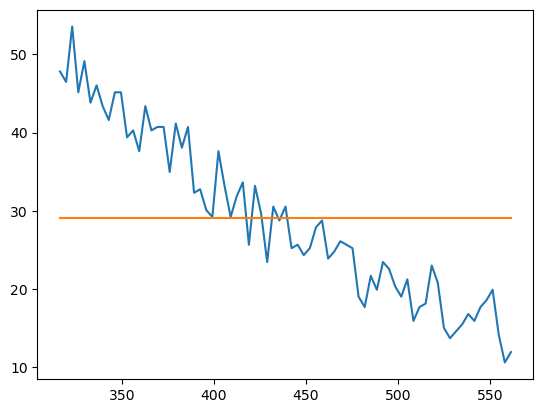

In [108]:
plt.plot(bins_c[mask_bins], rates[mask_bins])

initial_params = [1.0, 1.0, 1.0]
result = minimize(objective, initial_params, args=(bins_c[mask_bins], rates[mask_bins]))
params = result.x
a_fit, b_fit, c_fit = params

x_fit = np.linspace(min(bins_c[mask_bins]), max(bins_c[mask_bins]), 100)
y_fit = exponential_func(params, x_fit)

plt.plot(x_fit, y_fit)

Analysing run 4028 subrun 5


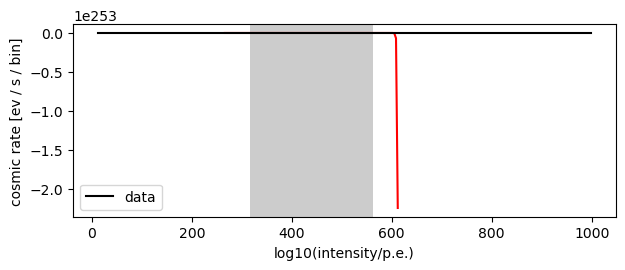

In [95]:
iii = 30

DICT = DICTS[iii]

print("Analysing run {} subrun {}".format(DICT["run"], DICT["srun"]))

fig, ax = plt.subplots(figsize=(7,2.5))

counts, _ = np.histogram(DICT["scale"][1]["intensity"], bins=bins)

rates = counts / DICT["dcheck"]["telapsed"] * bins_size

mask_bins = []
for b in bins_c:
    if b >= limsint[0] and b <= limsint[1]:
        mask_bins.append(True)
    else:
        mask_bins.append(False)

params, covariance = curve_fit(exponential_func, bins_c[mask_bins], rates[mask_bins])
a_fit, b_fit, c_fit = params
bins_space = np.linspace(limsint[0]-50, limsint[1]+50, 100)
# ax.plot(bins_space, exponential_func(bins_space, a_fit, b_fit, c_fit), color="r", zorder=1)

ax.plot(bins_c, rates, color="k", label="data")

ax.axvspan(limsint[0], limsint[1], zorder=-100, color="gray", alpha=0.4, ls="")
ax.legend()
ax.set_xlabel("log10(intensity/p.e.)")
ax.set_ylabel("cosmic rate [ev / s / bin]")
plt.show()

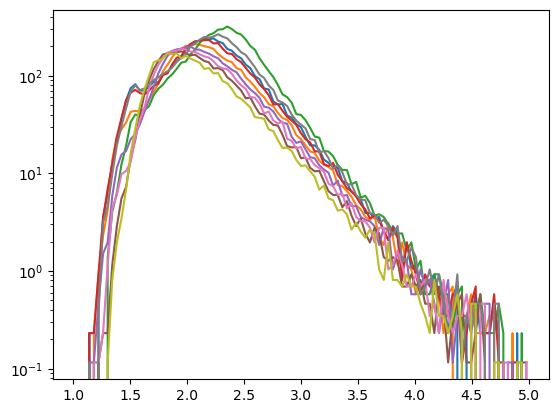

In [81]:
bins = np.linspace(1,5,100)
bins_c = bins[:-1] / 2 + bins[1:] / 2

histograms = []
for DICT in DICTS[1:2]:
    
    for sc in DICT["scale"].keys():
        hist, _  = np.histogram(DICT["scale"][sc]["log_intensity"], bins)
        telapsed = DICT["scale"][sc]["dragon_time"].iloc[-1] - DICT["scale"][sc]["dragon_time"].iloc[0]
        counts = hist / telapsed
    
        plt.plot(bins_c, counts)
plt.yscale("log")

In [ ]:
tables = []
for srun in [0,1,2,3]:
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_bad:05}.{srun:04}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 
    tables.append(table)

tables_good = []
for srun in [0]:
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_good:05}.{srun:04}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 
    tables_good.append(table)

## Calculate the rates and save the histogams and other data of each subrun

In [ ]:
bins = np.linspace(1,5,100)
bins_c = bins[:-1] / 2 + bins[1:] / 2

histograms_good = []
histograms_bad  = []
zds_good, azs_good = [], []
zds_bad, azs_bad   = [], []
for srun, tab in enumerate(tables):
    tsrun_datacheck = dcheck_bad.query(f"subrun == {srun}")
    counts, bin_edges = np.histogram(tab["log_intensity"], bins=bins)
    rates = counts / float(tsrun_datacheck["corrected_elapsed_time"].iloc[0])
    histograms_bad.append(rates)
    
    coszd = tsrun_datacheck["cos_zenith"].iloc[0]
    zds_bad.append(np.rad2deg(np.arccos(coszd)))
    azs_bad.append(tsrun_datacheck["az_tel"].iloc[0])

for srun, tab in enumerate(tables_good):
    tsrun_datacheck = dcheck_good.query(f"subrun == {srun}")
    counts, bin_edges = np.histogram(tab["log_intensity"], bins=bins)
    rates = counts / float(tsrun_datacheck["corrected_elapsed_time"].iloc[0])
    histograms_good.append(rates)
    
    coszd = tsrun_datacheck["cos_zenith"].iloc[0]
    zds_good.append(np.rad2deg(np.arccos(coszd)))
    azs_good.append(tsrun_datacheck["az_tel"].iloc[0])


## Plot the cosmics rates

In [ ]:
fig, (ax) = plt.subplots(figsize=(7,4))

for srun, tab in enumerate(tables_good):
    ax.plot(bins_c, histograms_good[srun], color="mediumblue", label=f"Run{run_good} (\"good\")" if srun == 0 else "")
    
for srun, tab in enumerate(tables[:1]):
    ax.plot(bins_c, histograms_bad[srun], color="c", label=f"Run{run_bad} (\"bad\")" if srun == 0 else "")

ax.axvline(np.log10(422), color="gray", ls="--", zorder=-1, label="422 p.e.")
ax.axvspan(np.log10(316), np.log10(562), color="gray", alpha=0.2, zorder=-2, label="Fit range", lw=0)

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("log10(intensity/p.e.)")

plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
rate_good = np.array(dcheck_good["ZD_corrected_cosmics_rate_at_422_pe"])
rate_bad  = np.array(dcheck_bad["ZD_corrected_cosmics_rate_at_422_pe"])
elpt_good, elpt_bad = np.cumsum(dcheck_good["elapsed_time"]), np.cumsum(dcheck_bad["elapsed_time"])
ratio = np.mean(rate_good)/np.mean(rate_bad)

print(f"RATIO = {ratio:.4f}")

fig, (ax) = plt.subplots(figsize=(12,3))

ax.plot(elpt_bad, rate_bad, color="c")
ax.plot(elpt_good, rate_good, color="mediumblue")
ax.axhline(np.mean(rate_good), ls="--", zorder=-3, color="mediumblue", label=f"Run{run_good} (\"good\")")
ax.axhline(np.mean(rate_bad), ls="--", zorder=-3, color="c", label=f"Run{run_bad} (\"bad\")")

ax.legend(loc=7)
ax.set_ylabel("dR/dI @ 422 p.e.")
ax.set_xlabel("time [s]")
ax.set_ylim(0.7, 2.1)
ax.grid()
ax.set_title(f"mean(good) / mean(bad) = {ratio:.3f}")

plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print([*np.linspace(1-0.6383, 1, 5)[:-1], *np.linspace(1, 1.6383, 5),*np.linspace(1.6383, 2, 5)[1:]])

In [ ]:
histograms = []
hist_npix  = []
bins_n = np.linspace(2, 1855, 1855-2)
scales = [0.3617, 0.521275, 0.68085, 0.840425, 1.0, 1.159575, 1.31915, 1.478725, 1.6383, 1.728725, 1.81915, 1.909575, 2]
for scale in scales:
    ext = f"_scaled{scale:.4f}" if scale != 1.0 else ""
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_bad:05}.{0:04}{ext}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 

    datacheck = dcheck_bad.query(f"subrun == 0")
    counts, bin_edges = np.histogram(table["log_intensity"], bins=bins)
    rates = counts / float(datacheck["corrected_elapsed_time"].iloc[0])

    counts_npix, _ = np.histogram(table["n_pixels"], bins=bins_n)
    rates_npix = counts_npix / float(datacheck["corrected_elapsed_time"].iloc[0])
    
    histograms.append(rates)
    hist_npix.append(rates_npix)
    
hist_good_npix, _ = np.histogram(tables[0]["n_pixels"], bins=bins_n)

In [ ]:
fig, (ax) = plt.subplots(figsize=(12,6))

ax.plot(bins_c, histograms_good[0], color="k", ls=":", label=f"Run{run_good} (\"good\")", zorder=100)
ax.plot(bins_c, histograms[4], color="k", ls="--", label=f"Run{run_good} (\"good\")" if srun == 0 else "", zorder=100)

pcols = ["b", "c", "r"]
colors = aux.get_colors_multiplot(scales, COLORS=pcols, ran=[0, 2])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [0, 2], cmap, label="scaling factor")

for i, scale in enumerate(scales):
    label = f"Scaled {scale:.3f}"
    kw = dict()
    ax.plot(bins_c, histograms[i], color=colors[i], label=label, zorder=-i, **kw)

ax.axvline(np.log10(422), color="gray", ls="--", zorder=-1, label="422 p.e.")
ax.axvspan(np.log10(316), np.log10(562), color="gray", alpha=0.2, zorder=-2, lw=0)

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("log10(intensity/p.e.)")

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
binlims = [37, 44]

fig, (ax) = plt.subplots(figsize=(12,5))


for i, scale in enumerate(scales):
    ax.plot(bins_c, histograms[i], color="lightgray",zorder=-100,)
    
    
pcols = ["b", "c", "r"]
colors = aux.get_colors_multiplot(scales, COLORS=pcols, ran=[0, 2])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [0, 2], cmap, label="scaling factor")


slopes = []
intercepts = []
for i, scale in enumerate(scales):
    
    x = bins_c[binlims[0]:binlims[1]]
    y = histograms[i][binlims[0]:binlims[1]]
    
    fit = np.poly1d(np.polyfit(x, np.log10(y), 1)) 
    
    slopes.append(fit[0])
    intercepts.append(fit(np.log10(422)))
        
    xx = np.linspace(0, 6)
    ax.plot(xx, 10**fit(xx), color=colors[i], label = f"Scaled {scale:.3f}")
    
fitgood = np.poly1d(np.polyfit(x, np.log10(histograms_good[0][binlims[0]:binlims[1]]), 1)) 
slopesgood = fitgood[0]
interceptsgood = fitgood(np.log10(422))


ax.plot(xx, 10**fitgood(xx), color="k", ls="--", label=f"Run{run_good} (\"good\")")
ax.axvspan(bins_c[binlims[0]:binlims[1]][0], bins_c[binlims[0]:binlims[1]][-1], color="k", alpha=0.2, ls="")

ax.set_yscale("log")
ax.legend()
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("log10(intensity/p.e.)")
ax.set_ylim(1e-1, 1e3)
ax.set_xlim(1,5.5)
ax.set_title(f"Fit in range {10**bins_c[binlims[0]:binlims[1]][0]:.0f}p.e. to {10**bins_c[binlims[0]:binlims[1]][-1]:.0f}p.e.")

plt.show()

In [ ]:
fig, (ax) = plt.subplots(figsize=(7,4))
axt = ax.twinx()

p1, = ax.plot(scales, slopes, color="k", marker="o", label="Power index")
p2, = axt.plot(scales, intercepts, color="g", marker="o", label="Power index")
ax.plot([], [], color="g", marker="o", label="Intercept @ 422 p.e.")
ax.axhline(slopesgood, color="k", ls="--")
ax.plot([], [], color="g", ls="--")
axt.axhline(interceptsgood, color="g", ls="--")

ax.legend(loc=8)
ax.set_ylabel("power index")
axt.set_ylabel("rate @ 422 p.e.")
ax.set_xlabel("Scaling factor")
ax.grid()
ax.yaxis.label.set_color(p1.get_color())
ax.tick_params(axis='y', colors=p1.get_color())
axt.yaxis.label.set_color(p2.get_color())
axt.tick_params(axis='y', colors=p2.get_color())

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, (ax) = plt.subplots(figsize=(13,6))

pcols = ["b", "y", "r"]
colors = aux.get_colors_multiplot(scales, COLORS=pcols, ran=[0, 2])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [0, 2], cmap, label="scaling factor")

for i, scale in enumerate(scales):
    ax.plot(bins_n[1:]/2+bins_n[:-1]/2, hist_npix[i], color=colors[i], label=f"Scaled {scale:.3f}", zorder=-i,)

ax.plot(bins_n[1:]/2+bins_n[:-1]/2, hist_good_npix, color="k", zorder=-i, label=f"Run{run_good} (\"good\")")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0, 250)
ax.legend(loc=(0.715, 0.32))
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("number of pixels")

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.hist(tables_good[0]["n_pixels"], 1000)
plt.xlim(0, 70)

In [ ]:
plt.hist(tables[0]["n_pixels"], 1000);
plt.xlim(0, 70)

In [ ]:
for i in tables[0]["n_pixels"]:
    print(i)

In [ ]:
bins_nn = np.logspace(np.log10(2), np.log10(1855), 50)

hist_nnpix  = []
for scale in scales:
    ext = f"_scaled{scale:.4f}" if scale != 1.0 else ""
    dl2_path = dir_dl2 + f"dl2_LST-1.Run{run_bad:05}.{0:04}{ext}.h5"
    table = pd.read_hdf(dl2_path, key="dl2/event/telescope/parameters/LST_LSTCam") 

    counts_npix, _ = np.histogram(table["n_pixels"], bins=bins_nn)
    rates_npix = counts_npix / float(datacheck["corrected_elapsed_time"].iloc[0])

    hist_nnpix.append(rates_npix)
    
hist_good_nnpix, _ = np.histogram(tables[0]["n_pixels"], bins=bins_nn)

In [ ]:
fig, (ax) = plt.subplots(figsize=(13,6))

pcols = ["b", "c", "r"]
colors = aux.get_colors_multiplot(scales, COLORS=pcols, ran=[0, 2])
cmap   = aux.create_cmap(pcols)
aux.plot_colorbar(fig, ax, [0, 2], cmap, label="scaling factor")

for i, scale in enumerate(scales):
    ax.plot(bins_nn[1:]/2+bins_nn[:-1]/2, hist_nnpix[i], color=colors[i], label=f"Scaled {scale:.3f}", zorder=-i,)

ax.plot(bins_nn[1:]/2+bins_nn[:-1]/2, hist_good_nnpix, color="k", zorder=-i, label=f"Run{run_good} (\"good\")")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0, 250)
ax.legend(loc=(0.715, 0.32))
ax.set_ylabel("cosmic rate per bin [ev/s]")
ax.set_xlabel("number of pixels")

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()